### Семинар №5. Логистическая регрессия

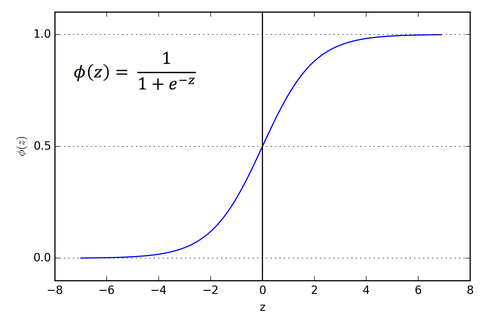

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
data = pd.read_csv("heart.csv")
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
data_encoded = pd.get_dummies(data, drop_first=True).astype(float)
data_encoded.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40.0,140.0,289.0,0.0,172.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49.0,160.0,180.0,0.0,156.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37.0,130.0,283.0,0.0,98.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48.0,138.0,214.0,0.0,108.0,1.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,54.0,150.0,195.0,0.0,122.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [5]:
X = data_encoded.drop(columns=["HeartDisease"])
y = data_encoded["HeartDisease"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((826, 15), (92, 15), (826,), (92,))

In [8]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
pipe.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [9]:
y_preds = pipe.predict(X_test)
y_preds_probs = pipe.predict_proba(X_test)

In [10]:
print(f"""
Acc     = {accuracy_score(y_test, y_preds)}
F1      = {f1_score(y_test, y_preds)}
ROC-AUC = {roc_auc_score(y_test, y_preds_probs[:, 1])}
""")


Acc     = 0.8804347826086957
F1      = 0.8865979381443299
ROC-AUC = 0.930952380952381



### Реализация LogReg

#### Log-loss
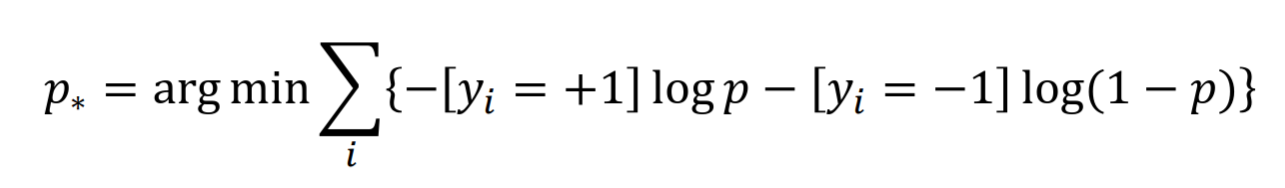

In [11]:
class MyLogReg:
    def __init__(self, lr=0.001, num_iter=1000) -> None:
        self.lr = lr
        self.num_iter = num_iter
        self.scaler = StandardScaler()

    def calculate_loss(self, y, y_pred):
        return (- y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)).mean()

    def grad_w(self, y, y_pred, x):
        grad_w = (-y + y_pred) @ x / x.shape[0]
        return grad_w

    def grad_b(self, y, y_pred):
        grad_b = (-y + y_pred)
        return grad_b.mean()

    def fit(self, X_train, y_train):
        X_train = np.array(X_train)
        self.scaler.fit(X_train)
        X_train = self.scaler.transform(X_train)
        y_train = np.array(y_train)
        self.weights = np.random.rand(X_train.shape[1])
        self.b = 1
        for i in range(self.num_iter):
            pred = self.predict(X_train)
            self.weights -= self.lr * self.grad_w(y_train, pred, X_train)
            self.b -= self.lr * self.grad_b(y_train, pred)

    def predict(self, X_test):
        X_test = np.array(X_test)
        X_test = self.scaler.transform(X_test)
        x = X_test @ self.weights + self.b
        return 1 / (1 + np.exp(-x))

In [12]:
my_logreg = MyLogReg(lr=0.01, num_iter=1000)
my_logreg.fit(X_train, y_train)

In [13]:
y_preds = (my_logreg.predict(X_test) >= 0.5).astype(int)
y_preds_probs = my_logreg.predict(X_test)

In [14]:
print(f"""
Acc     = {accuracy_score(y_test, y_preds)}
F1      = {f1_score(y_test, y_preds)}
ROC-AUC = {roc_auc_score(y_test, y_preds_probs)}
""")


Acc     = 0.8043478260869565
F1      = 0.8363636363636363
ROC-AUC = 0.9042857142857144

